In [1]:
# 📦 Step 1: Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.metrics.pairwise import cosine_similarity
import random
import tensorflow as tf


In [2]:
# 📁 Step 2: Set Paths
dataset_path = "dataset"
test_path = "testing_folder"
model_path = "model/rat_cnn_model.keras"
# 📂 Step 3: Create Dataset Directory if it doesn't exis    t

In [3]:
# 🖼️ Step 3: Data Preprocessing
img_size = (150, 150)
batch_size = 16

datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)


Found 118 images belonging to 2 classes.
Found 29 images belonging to 2 classes.


In [4]:
# 🧠 Step 4: Build CNN Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


c:\Users\Zain Latif\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     5,308,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,327,937 (20.32 MB)

 Trainable params: 5,327,937 (20.32 MB)

 Non-trainable params: 0 (0.00 B)

In [5]:
# 🚀 Step 5: Train Model
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)


Epoch 1/5


c:\Users\Zain Latif\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 264ms/step - accuracy: 0.4296 - loss: 2.0327 - val_accuracy: 0.6207 - val_loss: 0.6973
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.5935 - loss: 0.6773 - val_accuracy: 0.6207 - val_loss: 0.6893
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 192ms/step - accuracy: 0.6497 - loss: 0.6516 - val_accuracy: 0.6207 - val_loss: 0.6749
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 190ms/step - accuracy: 0.6174 - loss: 0.6472 - val_accuracy: 0.6207 - val_loss: 0.6712
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 193ms/step - accuracy: 0.6063 - loss: 0.5857 - val_accuracy: 0.6552 - val_loss: 0.6325


In [6]:
# 💾 Step 6: Save Model
os.makedirs("model", exist_ok=True)
model.save(model_path)


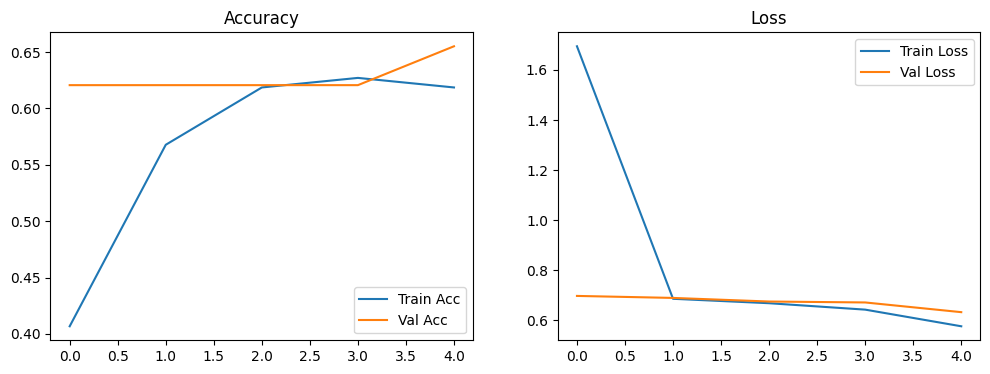

In [7]:
# 📈 Step 7: Plot Accuracy & Loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.legend()

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Prediction: No Rat Detected ❌ (0.27)


C:\Users\Zain Latif\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


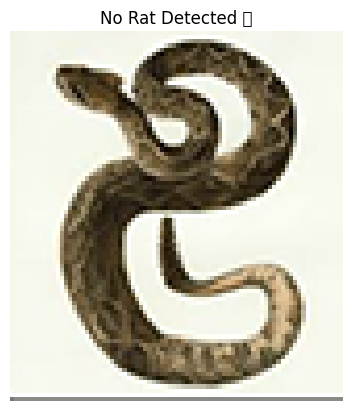

In [8]:
# 🔍 Step 8: Predict Image in testing_folder
model = load_model(model_path)

test_img_name = os.listdir(test_path)[0]
test_img_path = os.path.join(test_path, test_img_name)

img = load_img(test_img_path, target_size=img_size)
img_array = img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

prediction = model.predict(img_array)[0][0]
result = "Rat Detected 🐀" if prediction > 0.5 else "No Rat Detected ❌"

print(f"Prediction: {result} ({prediction:.2f})")

plt.imshow(load_img(test_img_path))
plt.axis('off')
plt.title(result)
plt.show()
